Copyright (c) Microsoft Corporation. All rights reserved.

![alt text](https://www.microsoftevents.com/accounts/register123/microsoft/msft-v1/c-and-e-v2/events/ce2-ce-2c-mec0028133/Azure%20Academy%20banner_Data.png "Logo Title Text 1")

# HOL01: Azure Machine Learning serice

This lab guides you through Azure Machine Learning service - creation & setup, building experiment and train model (also use automated machine learning technique).

In this use case you build a regression model to predict NYC taxi fare prices. 
This process accepts training data and configuration settings, and automatically iterates through combinations of different feature normalization/standardization methods, models, and hyperparameter settings to arrive at the best model.

In this lab you learn the following tasks:

* Create Azure Machine Learning Workspace
* Download, transform, and clean data using Azure Open Datasets
* Train an automated machine learning regression model
* Calculate model accuracy

If you don’t have an Azure subscription, create a free account before you begin. Try the [free or paid version](https://aka.ms/AMLFree) of Azure Machine Learning service today.

## Prerequisites

* Existing AML Workspace - step can be found on GitHub repo for this lab [AzureAcademy-DataAnalyst-II-ML-AI-HOL01-AML.md](https://github.com/michalmar/azure-labs/blob/master/AzureAcademy-DataAnalyst-II-ML-AI-HOL01-AML.md)

* check and update VM environemt

`pip install --upgrade azureml-sdk[explain,automl,notebooks] azureml-opendatasets azureml-widgets "urllib3==1.24"`


# PART 1: Download and prepare data

We will use [Azure Open Datasets](https://docs.microsoft.com/en-us/azure/open-datasets/overview-what-are-open-datasets) - curated public datasets that you can use to add scenario-specific features to machine learning solutions for more accurate models. Open Datasets are in the cloud on Microsoft Azure and are readily available to Azure Databricks, Machine Learning service, and Machine Learning Studio. You can also access the datasets through APIs and use them in other products, such as Power BI and Azure Data Factory.


We will use particular dataset: [NYC Taxi & Limousine Commission - green taxi trip records](https://azure.microsoft.com/en-us/services/open-datasets/catalog/nyc-taxi-limousine-commission-green-taxi-trip-records/)



Import the necessary packages. The Open Datasets package contains a class representing each data source (`NycTlcGreen` for example) to easily filter date parameters before downloading.

In [1]:
from azureml.opendatasets import NycTlcGreen
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

%config IPCompleter.greedy=True

Begin by creating a dataframe to hold the taxi data. When working in a non-Spark environment, Open Datasets only allows downloading one month of data at a time with certain classes to avoid `MemoryError` with large datasets. To download taxi data, iteratively fetch one month at a time, and before appending it to `green_taxi_df` randomly sample 2,000 records from each month to avoid bloating the dataframe. Then preview the data.

In [ ]:
# green_taxi_df = pd.read_csv("./data/taxi_raw_df.csv")
# green_taxi_df['lpepPickupDatetime'] = green_taxi_df['lpepPickupDatetime'].astype('datetime64[ns]')
# # green_taxi_df.head(10)

In [ ]:
green_taxi_df = pd.DataFrame([])
start = datetime.strptime("1/1/2015","%m/%d/%Y")
end = datetime.strptime("1/31/2015","%m/%d/%Y")

for sample_month in range(12):
    temp_df_green = NycTlcGreen(start + relativedelta(months=sample_month), end + relativedelta(months=sample_month)) \
        .to_pandas_dataframe()
    green_taxi_df = green_taxi_df.append(temp_df_green.sample(2000))

green_taxi_df.head(10)

In [ ]:
green_taxi_df.to_parquet("./data/taxi_raw_df.parquet")

In [ ]:
green_taxi_df = pd.read_parquet("./data/taxi_raw_df.parquet")
green_taxi_df.head()

Now that the initial data is loaded, define a function to create various time-based features from the pickup datetime field. This will create new fields for the month number, day of month, day of week, and hour of day, and will allow the model to factor in time-based seasonality. 

Use the `apply()` function on the dataframe to iteratively apply the `build_time_features()` function to each row in the taxi data.

In [ ]:
def build_time_features(vector):
    pickup_datetime = vector[0]
    month_num = pickup_datetime.month
    day_of_month = pickup_datetime.day
    day_of_week = pickup_datetime.weekday()
    hour_of_day = pickup_datetime.hour
    
    return pd.Series((month_num, day_of_month, day_of_week, hour_of_day))

green_taxi_df[["month_num", "day_of_month","day_of_week", "hour_of_day"]] = green_taxi_df[["lpepPickupDatetime"]].apply(build_time_features, axis=1)
green_taxi_df.head(10)

Remove some of the columns that you won't need for training or additional feature building.

In [ ]:
columns_to_remove = ["lpepPickupDatetime", "lpepDropoffDatetime", "puLocationId", "doLocationId", "extra", "mtaTax",
                     "improvementSurcharge", "tollsAmount", "ehailFee", "tripType", "rateCodeID", 
                     "storeAndFwdFlag", "paymentType", "fareAmount", "tipAmount"
                    ]
for col in columns_to_remove:
    green_taxi_df.pop(col)
    
green_taxi_df.head(5)

### Cleanse data 

Run the `describe()` function on the new dataframe to see summary statistics for each field.

In [ ]:
green_taxi_df.describe()

In [ ]:
# Will allow us to embed images in the notebook
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]
boxplot = green_taxi_df.boxplot(column=list(green_taxi_df.columns[1:-4]))

From the summary statistics, you see that there are several fields that have outliers or values that will reduce model accuracy. First filter the lat/long fields to be within the bounds of the Manhattan area. This will filter out longer taxi trips or trips that are outliers in respect to their relationship with other features. 

Additionally filter the `tripDistance` field to be greater than zero but less than 31 miles (the haversine distance between the two lat/long pairs). This eliminates long outlier trips that have inconsistent trip cost.

Lastly, the `totalAmount` field has negative values for the taxi fares, which don't make sense in the context of our model, and the `passengerCount` field has bad data with the minimum values being zero.

Filter out these anomalies using query functions, and then remove the last few columns unnecessary for training.

In [ ]:
final_df = green_taxi_df.query("pickupLatitude>=40.53 and pickupLatitude<=40.88")
final_df = final_df.query("pickupLongitude>=-74.09 and pickupLongitude<=-73.72")
final_df = final_df.query("tripDistance>=0.25 and tripDistance<31")
final_df = final_df.query("passengerCount>0 and totalAmount>0")

columns_to_remove_for_training = ["pickupLongitude", "pickupLatitude", "dropoffLongitude", "dropoffLatitude"]
for col in columns_to_remove_for_training:
    final_df.pop(col)

Call `describe()` again on the data to ensure cleansing worked as expected. You now have a prepared and cleansed set of taxi, holiday, and weather data to use for machine learning model training.

In [ ]:
final_df.describe()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_df, test_size=0.2, random_state=223)

print(f'train:{len(list(train["vendorID"]))} \ntest: {len(list(test["vendorID"]))}')

final_df.to_csv("./data/taxi_final_df.csv", index=False)
train.to_csv("./data/taxi_final_df_train.csv", index=False)
test.to_csv("./data/taxi_final_df_test.csv", index=False)

## PART 2: Train within notebook regression model with AML Serice

In PART2 you train simple regression model within the notebook environement while logging metrics and output trhough AML service Experiment. Also you try to run single parameter sweep of the regression model.

* first you create configure a connection to workspace
* then run the simple training
* lastly you run simple parameter sweep of a regression model
* review results

In [2]:
final_df = pd.read_csv("./data/taxi_final_df.csv")
# final_df.head(10)

### Configure workspace


Create a workspace object from the existing workspace. A [Workspace](https://docs.microsoft.com/python/api/azureml-core/azureml.core.workspace.workspace?view=azure-ml-py) is a class that accepts your Azure subscription and resource information. It also creates a cloud resource to monitor and track your model runs. `Workspace.from_config()` reads the file **config.json** and loads the authentication details into an object named `ws`. `ws` is used throughout the rest of the code in this tutorial.

In [50]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
# print(f"Name: {ws.name}, Resource group: {ws.resource_group}, Location: {ws.location}, Subscription: {ws.subscription_id}")
output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
# output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.9.0
Subscription ID,6ee947fa-0d77-4915-bf68-4a83a8bec2a4
Workspace,mlops-demo
Resource Group,mlops-rg
Location,westeurope


### Train locally within notebook

Split the data into training and test sets by using the `train_test_split` function in the `scikit-learn` library. This function segregates the data into the x (**features**) data set for model training and the y (**values to predict**) data set for testing. The `test_size` parameter determines the percentage of data to allocate to testing. The `random_state` parameter sets a seed to the random generator, so that your train-test splits are deterministic.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import lightgbm as lgb


y_df = final_df.pop("totalAmount")
x_df = final_df

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=223)

Let's use scikit-learn to train a simple LightGBM regression model.  We use AML to record interesting information about the model in an Experiment.  An Experiment contains a series of trials called Runs.  During this trial we use AML in the following way:
* We access an experiment from our AML workspace by name, which will be created if it doesn't exist
* We use `start_logging` to create a new run in this experiment
* We use `run.log()` to record a parameter, num_leaves, and an accuracy measure - the Mean Squared Error (MSE) to the run.  We will be able to review and compare these measures in the Azure Portal at a later time.
* We store the resulting model in the **outputs** directory, which is automatically captured by AML when the run is complete.
* We use `run.complete()` to indicate that the run is over and results can be captured and finalized

In [ ]:
from azureml.core import Experiment

# Get an experiment object from Azure Machine Learning
experiment = Experiment(workspace=ws, name="train-within-notebook-lightgbm")

# Create a run object in the experiment
run =  experiment.start_logging()


# Log the algorithm parameters to the run
run.log('num_leaves', 31)
run.log('learning_rate', 0.05)
run.log('n_estimators', 20)

# setup model, train and test
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
model_gbm = gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

preds = model_gbm.predict(x_test)

# Output the Mean Squared Error to the notebook and to the run
print('Mean Squared Error is', mean_squared_error(y_test, preds))
run.log('mse', mean_squared_error(y_test, preds))

# Save the model to the outputs directory for capture
model_file_name = './outputs/model.pkl'

joblib.dump(value = model_gbm, filename = model_file_name)

# upload the model file explicitly into artifacts 
run.upload_file(name = model_file_name, path_or_stream = model_file_name)

# Complete the run
run.complete()

### Simple parameter sweep
Now let's take the same concept from above and modify the **num_leaves** parameter.  For each value of num_leaves we will create a run that will store metrics and the resulting model.  In the end we can use the captured run history to determine which model was the best for us to deploy. 

Note that by using `with experiment.start_logging() as run` AML will automatically call `run.complete()` at the end of each loop.

This example also uses the **tqdm** library to provide a thermometer feedback

In [ ]:
import numpy as np
from tqdm import tqdm
# experiment = Experiment(workspace=ws, name="train-locally-within-notebook-sweep3")
# list of numbers from 0 to 1.0 with a 0.05 interval
num_leaves_sweep = np.arange(5, 35, 2)
mses = []

with experiment.start_logging() as run:

    for num_leaves in tqdm(num_leaves_sweep):
        # create a bunch of runs, each train a model with a different parameters
        with run.child_run() as child_run:
            gbm = lgb.LGBMRegressor(num_leaves=num_leaves,
                                    learning_rate=0.05,
                                    n_estimators=20,
                                    silent=True)
            model_gbm = gbm.fit(x_train, y_train,
                    eval_set=[(x_test, y_test)],
                    eval_metric='l1',
                    early_stopping_rounds=5
                    , verbose=False)

            preds = model_gbm.predict(x_test)
            mse = mean_squared_error(y_true=y_test, y_pred=preds)

            # log alpha, mean_squared_error and feature names in run history
            child_run.log(name="num_leaves", value=num_leaves)
            child_run.log(name="mse", value=mse)
            mses.append(mse)

    run.log_list(name="mses", value=mses, description='')


In [ ]:
from azureml.widgets import RunDetails

RunDetails(run).show()

### Viewing run results
Azure Machine Learning stores all the details about the run in the Azure cloud.  Let's access those details by retrieving a link to the run using the default run output.  Clicking on the resulting link will take you to an interactive page presenting all run information.

In [ ]:
run

An experiment is a logical container in an Azure ML Workspace. It contains a series of trials called Runs. As such, it hosts run records such as run metrics, logs, and other output artifacts from your experiments.

The purpose of this step is to have data points to test the finished model that haven't been used to train the model, in order to measure true accuracy. 

In other words, a well-trained model should be able to accurately make predictions from data it hasn't already seen. You now have data prepared for auto-training a machine learning model.

## PART 3: Train Regresion model on AML remote Compute

In PART 3, we focus on training models on Remote AML Compute and is divided into two parts where:
A) you train single Regreesion model similar to previous section, just using remote compute
B) you train multiple Regression models at once and select the best one via Autmated ML componement of Azure Machine Learning service. This happens on remote AML compute - simple auto-scaled cluster of machines for parallel training.

The steps are:
* configure datasource - remote storage shared between the parallel runs
* configure AML compute target
* configure and run Automated ML Experiment
* review results

Get default blob store associated with your workspace. Alternatively, you can attach your own blob storage to the Workspace - see [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-access-data).

In [5]:
ds = ws.datastores['workspaceblobstore']
# ds = ws.get_default_datastore()
for attr, value in ds.__dict__.items():
    if (attr in ['name', 'datastore_type', 'container_name', 'account_name']):
        print(f"{attr}: {value}")

container_name: azureml-blobstore-f6e87a86-c769-4de1-b661-968b2c33123c
account_name: mlopsmmaamlsa


Upload prepared data into associated Datastore.

In [6]:
ds.upload(src_dir='./data', target_path='data', overwrite=True, show_progress=True)

Uploading an estimated of 5 files
Uploading ./data/dummy
Uploading ./data/taxi_final_df.csv
Uploading ./data/taxi_final_df_test.csv
Uploading ./data/taxi_final_df_train.csv
Uploading ./data/taxi_raw_df.parquet
Uploaded ./data/dummy, 1 files out of an estimated total of 5
Uploaded ./data/taxi_final_df.csv, 2 files out of an estimated total of 5
Uploaded ./data/taxi_final_df_test.csv, 3 files out of an estimated total of 5
Uploaded ./data/taxi_final_df_train.csv, 4 files out of an estimated total of 5
Uploaded ./data/taxi_raw_df.parquet, 5 files out of an estimated total of 5
Uploaded 5 files


$AZUREML_DATAREFERENCE_babc26e08e944bdc8257ee129e60abed

### Configure Compute Target (SDK)

Create Compute target in Portal - alternativelly you could create using Pyhton SDK.

Reuse the name of the cluster compute you created in preview step and set appropriatelly variable:

```python
amlcompute_cluster_name = "<#Name your cluster#>" 

In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "aml-cluster" #Name your cluster
# amlcompute_cluster_name = "azdemocluster-f" #Name your cluster

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_d2_v2', # Standard_F4s_v2
                                                           max_nodes=10)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

# Use the 'status' property to get a detailed status for the current cluster. 
cts = compute_target.status.serialize()
print(f'Found existing compute target: {amlcompute_cluster_name}\n({"cluster is running" if (int(cts["currentNodeCount"])>0) else "cluster is idle"}) currentNodeCount: {cts["currentNodeCount"]}, vmPriority: {cts["vmPriority"]}, vmSize: {cts["vmSize"]}')


Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
Found existing compute target: aml-cluster
(cluster is running) currentNodeCount: 1, vmPriority: Dedicated, vmSize: STANDARD_D2_V2


Project folder gets uploaded into docker and will be the ``working directory`` of the executed code.

In [ ]:
# from azureml.core.runconfig import DataReferenceConfiguration

# dr = DataReferenceConfiguration(datastore_name=ds.name, 
#                    path_on_datastore='data', 
#                    path_on_compute='/tmp/azureml_runs',
#                    mode='download', # download files from datastore to compute target
#                    overwrite=False)

In [11]:
import os

project_folder = "aml_prj"

if not os.path.exists(project_folder):
    os.makedirs(project_folder)
else:
    print(f"folder '{project_folder}' aready there")

folder 'aml_prj' aready there


### Part 3 A: Train simple Regression model on remote AML Compute

In [ ]:
from azureml.core import Dataset

dataset = Dataset.File.from_files((ds, 'data/taxi_final_df_train.csv'))
dataset

In [ ]:
from azureml.core import Experiment
exp = Experiment(workspace=ws, name="train-on-amlcompute-simple")


In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk',
                                                                             'azureml-dataprep[pandas,fuse]',
                                                                             'scikit-learn',
                                                                             'lightgbm',
                                                                            'joblib'])

We must configure the run based on environemnt, script folder with main script and arguments - such as dataset.

**Important** the script is just an ordinary `*.py` file located in the script folder named `train.py`

In [ ]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory=project_folder, 
                      script='train.py', 
                      arguments =[dataset.as_named_input('taxi_data').as_mount()])

src.run_config.framework = 'python'
src.run_config.environment = conda_env
src.run_config.target = compute_target.name
# src.run_config.data_references = {ds.name: dr}

In [ ]:
run = exp.submit(config=src)

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

### Part 3B: Trainng multiple models in parallel using Automated ML

Observe parameters of DataReferenceConfiguration:

* `path_on_datastore`...folder in container
* `path_on_compute`...folder where the data is mounted/downloaded
* `mode`...wheter download or just mount

The RunConfiguration sets the docker Python environment - packages and Conda dependencies.

In [9]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
import pkg_resources

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to the Linux DSVM
conda_run_config.target = compute_target
# set the data reference of the run coonfiguration
# conda_run_config.data_references = {ds.name: dr}

pandas_dependency = 'pandas==' + pkg_resources.get_distribution("pandas").version

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]'], conda_packages=['numpy',pandas_dependency])
conda_run_config.environment.python.conda_dependencies = cd

### Automatically train a model

To automatically train a model, take the following steps:
1. Define settings for the experiment run. Attach your training data to the configuration, and modify settings that control the training process.
1. Submit the experiment for model tuning. After submitting the experiment, the process iterates through different machine learning algorithms and hyperparameter settings, adhering to your defined constraints. It chooses the best-fit model by optimizing an accuracy metric.

#### Define training settings

Define the experiment parameter and model settings for training. View the full list of [settings](https://docs.microsoft.com/azure/machine-learning/service/how-to-configure-auto-train). Submitting the experiment with these default settings will take approximately 5-10 min, but if you want a shorter run time, reduce the `iterations` parameter.


|Property| Value in this tutorial |Description|
|----|----|---|
|**iteration_timeout_minutes**|2|Time limit in minutes for each iteration. Reduce this value to decrease total runtime.|
|**iterations**|20|Number of iterations. In each iteration, a new machine learning model is trained with your data. This is the primary value that affects total run time.|
|**primary_metric**| spearman_correlation | Metric that you want to optimize. The best-fit model will be chosen based on this metric.|
|**preprocess**| True | By using **True**, the experiment can preprocess the input data (handling missing data, converting text to numeric, etc.)|
|**verbosity**| logging.INFO | Controls the level of logging.|
|**n_cross_validations**|5|Number of cross-validation splits to perform when validation data is not specified.|
|**max_concurrent_iterations**|10|Number of parallel runs - should according to cluster size.|


In [20]:
from azureml.train.automl import AutoMLConfig
import azureml.dataprep as dprep
from azureml.core.dataset import Dataset

# train_data_dprep = dprep.auto_read_file(path=ds.path("data/taxi_final_df_train.csv"))
# valid_data_dprep = dprep.auto_read_file(path=ds.path("data/taxi_final_df_test.csv"))

train_data_dprep = Dataset.Tabular.from_delimited_files(path=(ds, './data/taxi_final_df_test.csv'))
valid_data_dprep = Dataset.Tabular.from_delimited_files(path=(ds, './data/taxi_final_df_train.csv'))


automl_config = AutoMLConfig(task='regression',
                            iteration_timeout_minutes=30,
                            iterations=3,
                            featurization='auto',
                            blacklist_models = ["XGBoostRegressor","ElasticNet"],
                            primary_metric='normalized_root_mean_squared_error',
                            training_data=train_data_dprep,
                            validation_data=valid_data_dprep,                             
                            label_column_name="totalAmount",
                            debug_log='automl.log',
                            run_configuration=conda_run_config,
                            model_explainability=False,
                            max_concurrent_iterations=10,
                            path= project_folder)

Automated machine learning pre-processing steps (feature normalization, handling missing data, converting text to numeric, etc.) become part of the underlying model. When using the model for predictions, the same pre-processing steps applied during training are applied to your input data automatically.

#### Train the automatic regression model

Create an experiment object in your workspace. An experiment acts as a container for your individual runs. Pass the defined `automl_config` object to the experiment, and set the output to `True` to view progress during the run. 

After starting the experiment, the output shown updates live as the experiment runs. For each iteration, you see the model type, the run duration, and the training accuracy. The field `BEST` tracks the best running training score based on your metric type.

During the training / experiment running you can observe the result and changes in Azure Portal. Also you can view the state of the runs and results using Widget below in sub-section **Explore results**

In [21]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, 'train-on-amlcompute-automl')
remote_run = experiment.submit(automl_config, show_output=False)

Running on remote or ADB.


### Explore the results

Explore the results of automatic training with a [Jupyter widget](https://docs.microsoft.com/python/api/azureml-widgets/azureml.widgets?view=azure-ml-py). The widget allows you to see a graph and table of all individual run iterations, along with training accuracy metrics and metadata. Additionally, you can filter on different accuracy metrics than your primary metric with the dropdown selector.

In [22]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [ ]:
 raise Exception('### INTENDED STOP ### to wait for asynchronous AutoML Job')

### Review trained model & results

#### Retrieve the best model

Select the best model from your iterations. The `get_output` function returns the best run and the fitted model for the last fit invocation. By using the overloads on `get_output`, you can retrieve the best run and fitted model for any logged metric or a particular iteration.

In [23]:
best_run, fitted_model = remote_run.get_output()
print("Best Run:")
print(best_run)

print("")
print("Fitted model:")
print(fitted_model)

Best Run:
Run(Experiment: train-on-amlcompute-automl,
Id: AutoML_ce99eaa1-3715-4723-9d8a-c95babcb2306_0,
Type: azureml.scriptrun,
Status: Completed)

Fitted model:
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...      silent=True, subsample=1.0, subsample_for_bin=200000,
         subsample_freq=0, verbose=-1))]),
          stddev=None)


#### Test the best model accuracy

Use the best model to run predictions on the test data set to predict taxi fares. The function `predict` uses the best model and predicts the values of y, **trip cost**, from the `x_test` data set. Print the first 10 predicted cost values from `y_predict`.


In [24]:
test = pd.read_csv("./data/taxi_final_df_test.csv")

In [25]:
test.head()

,vendorID,passengerCount,tripDistance,totalAmount,month_num,day_of_month,day_of_week,hour_of_day
0,2,1,1.45,8.80,6,3,2,13
1,2,1,4.03,21.36,5,2,5,17
2,2,1,1.53,12.80,10,30,4,18
3,1,1,0.70,5.80,10,1,3,21
4,2,1,5.29,20.76,8,14,4,22


In [26]:
y_test = test.pop("totalAmount")
x_test = test

In [27]:
y_predict = fitted_model.predict(x_test)
print(y_predict[:10])

[10.13649246 22.13476913 11.16101544  7.01461835 22.47588396 21.44308391
 11.05709521  7.66891627 23.29342338  8.80508919]


Calculate the `root mean squared error` of the results. Convert the `y_test` dataframe to a list to compare to the predicted values. The function `mean_squared_error` takes two arrays of values and calculates the average squared error between them. Taking the square root of the result gives an error in the same units as the y variable, **cost**. It indicates roughly how far the taxi fare predictions are from the actual fares.


In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = y_test.values.flatten().tolist()
rmse = sqrt(mean_squared_error(y_actual, y_predict))
print(f"RMSE: {rmse}")

RMSE: 2.6261801995628886


Run the following code to calculate mean absolute percent error (MAPE) by using the full `y_actual` and `y_predict` data sets. This metric calculates an absolute difference between each predicted and actual value and sums all the differences. Then it expresses that sum as a percent of the total of the actual values.


In [29]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)

Model MAPE:
0.10988152394428385

Model Accuracy:
0.8901184760557161


From the two prediction accuracy metrics, you see that the model is fairly good at predicting taxi fares from the data set's features, typically within +- $4.00, and approximately 15% error. 

The traditional machine learning model development process is highly resource-intensive, and requires significant domain knowledge and time investment to run and compare the results of dozens of models. Using automated machine learning is a great way to rapidly test many different models for your scenario.

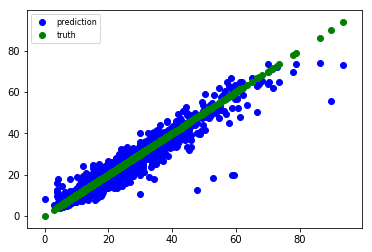

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
test_pred = plt.scatter(y_actual, y_predict, color='b')
test_test = plt.scatter(y_actual, y_actual, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

NameError: name 'np' is not defined

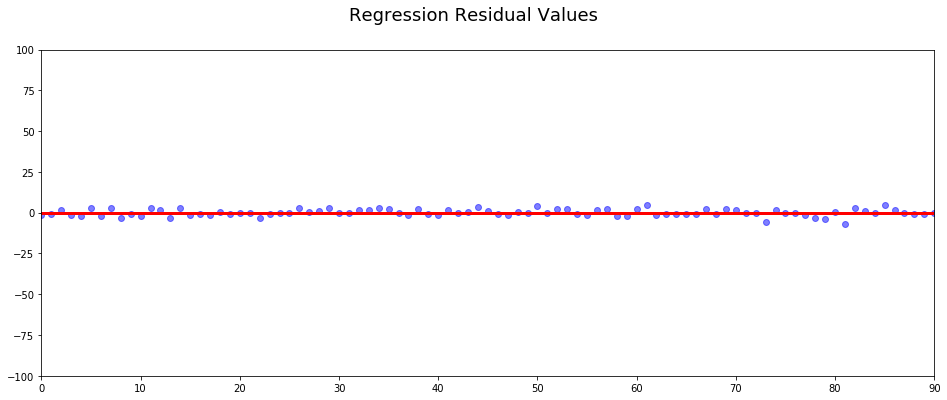

In [32]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

y_residual_test = y_test - y_predict

# Set up a multi-plot chart.
f, a1 = plt.subplots(1, 1)
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of test set.
a1.axis([0, 90, -100, 100])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_predict))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_predict)),fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

plt.show()

## PART 4: Model Deployment [optional]

In this part of the lab, you use trained best model to create deployment as webservice in Azure Container Instance (ACI). 

The steps of deployment process are:

* Model registration
* Creatig scoring script (the heart of WS)
* Setup inference environment
* Deploy to ACI as WS

### Model registration

In [33]:
import pickle
filename = os.path.join(project_folder,"automl_best_model.pkl")
pickle.dump(fitted_model, open(filename, 'wb'))

In [73]:
from azureml.core.model import Model

model = Model.register(model_path = "./{}/automl_best_model.pkl".format(project_folder),
                       model_name = "nyc_regression",
                       tags = {'area': "NYC", 'type': "regression"},
                       description = "Azure Academy - NYC model",
                       workspace = ws)

Registering model nyc_regression


#### Get Model

You can get the registered model anytime as this is accessible from within your workspace.

In [54]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

automl_best_model.pkl version: 4
	 area : NYC
	 type : regression


diabetes_model version: 12
	 Training context : Inline Training
	 AUC : 0.8826266301303927
	 Accuracy : 0.8991111111111111


diabetes_model version: 11
	 Training context : Hyperdrive
	 AUC : 0.856969468262725
	 Accuracy : 0.7891111111111111


diabetes_model version: 10
	 Training context : Inline Training
	 AUC : 0.8763644957460569
	 Accuracy : 0.8896666666666667


diabetes_model version: 9
	 Training context : Inline Training
	 AUC : 0.8745907756604805
	 Accuracy : 0.8866666666666667


diabetes_model version: 8
	 Training context : Pipeline


diabetes_model version: 7
	 Training context : Azure ML compute
	 AUC : 0.8835848667626378
	 Accuracy : 0.8982222222222223


diabetes_model version: 6
	 Training context : Estimator + Environment (Decision Tree)
	 AUC : 0.882273153182487
	 Accuracy : 0.8977777777777778


diabetes_model version: 5
	 Training context : SKLearn Estimator (file dataset)
	 AUC : 0.846851712258014
	 A

In [74]:
from azureml.core.model import Model
import os

model = Model(workspace=ws, name="nyc_regression")
model

Model(workspace=Workspace.create(name='mlops-demo', subscription_id='6ee947fa-0d77-4915-bf68-4a83a8bec2a4', resource_group='mlops-rg'), name=nyc_regression, id=nyc_regression:1, version=1, tags={'area': 'NYC', 'type': 'regression'}, properties={})

In [75]:
model

Model(workspace=Workspace.create(name='mlops-demo', subscription_id='6ee947fa-0d77-4915-bf68-4a83a8bec2a4', resource_group='mlops-rg'), name=nyc_regression, id=nyc_regression:1, version=1, tags={'area': 'NYC', 'type': 'regression'}, properties={})

### Scoring Script

The scoring script is basically getting the model, reading the input data and running/scoring the model and present outputs. It is tipically in separate folder but for this lab we will use the same forlder as for training.

If this is a AutoML model - you can check the scoring script in the particular run of the AutomML in `outputs` folder (in Portal).

In [37]:
import os
script_folder = os.path.join(project_folder)

In [76]:
%%writefile $script_folder/score.py

import pickle
import json
import numpy as np
from sklearn.externals import joblib
# import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import azureml.train.automl

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType


def init():
    global model
    # note here "automl_best_model.pkl" is the name of the model registered under
    model_path = Model.get_model_path(model_name='nyc_regression')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)


# create schema of incomming request and outgoing response
input_sample = np.array([2,1,0.93,6,20,5,22])
output_sample = np.array([0.93])

@input_schema('data', NumpyParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))

# main function representing the actual scoring phase
def run(data):
    try:
        result = model.predict(data.reshape(1, -1))
        # you can return any datatype as long as it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Overwriting aml_prj/score.py


In [90]:
%%writefile $script_folder/score.py

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import json
import pickle
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType


input_sample = pd.DataFrame({"vendorID": pd.Series(["2.0"], dtype="float64"), "passengerCount": pd.Series(["1.0"], dtype="float64"), "tripDistance": pd.Series(["1.45"], dtype="float64"), "month_num": pd.Series(["6.0"], dtype="float64"), "day_of_month": pd.Series(["3.0"], dtype="float64"), "day_of_week": pd.Series(["2.0"], dtype="float64"), "hour_of_day": pd.Series(["13.0"], dtype="float64")})
output_sample = np.array([0])


def init():
    global model
    # This name is model.id of model that we want to deploy deserialize the model file back
    # into a sklearn model
    model_path = Model.get_model_path(model_name = 'nyc_regression')
    model = joblib.load(model_path)


@input_schema('data', PandasParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(data):
    try:
        result = model.predict(data)
        return json.dumps({"result": result.tolist()})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})


Overwriting aml_prj/score.py


### Create Inference Configuration


To deploy a model to Azure Container Instances, create a **deployment configuration** that describes the compute resources needed. For example, number of cores and memory. You also need an **inference configuration**, which describes the environment needed to host the model and web service. For more information on creating the inference configuration, see [How and where to deploy models](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where).

In [84]:
%%writefile $script_folder/myenv.yml

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-train-automl-runtime==1.8.0.post1
  - inference-schema
  - azureml-explain-model==1.8.0
  - azureml-defaults==1.8.0
- numpy>=1.16.0,<=1.16.2
- pandas>=0.21.0,<=0.23.4
- scikit-learn>=0.19.0,<=0.20.3
- py-xgboost<=0.90
- fbprophet==0.5
- psutil>=5.2.2,<6.0.0
channels:
- anaconda
- conda-forge

Overwriting aml_prj/myenv.yml


In [91]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python",
                                   entry_script=script_folder+"/score.py",
                                   conda_file=script_folder+"/myenv.yml")



### Create Deployment Configuration

`deploy_configuration(cpu_cores=None, memory_gb=None, tags=None, properties=None, description=None, location=None, auth_enabled=None, ssl_enabled=None, enable_app_insights=None, ssl_cert_pem_file=None, ssl_key_pem_file=None, ssl_cname=None, dns_name_label=None)`

In [92]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.exceptions import WebserviceException

In [93]:
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 2, memory_gb = 4)

### Deploy

Final step is the actual deployment. Use deployment config and inference config and the name of the service.

> note: If you see error that serice already exists, simple use `service.delete()`

> note: This steps may take up to 15 mins
> * it needs to create an docker image from the model and the configuration
> * create ACI with the parameters
> * deploy the docker into ACI

In [94]:
aci_service_name = 'hol-nyc-realtime3'

service = Model.deploy(ws, aci_service_name, [model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)

Running.......................................................................................................................................................................................................................................................
TimedOut


ERROR - Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: c89b7b1c-c17a-4805-8ead-fb9f38f518c4
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. You can run print(service.state) from the python SDK to retrieve the current state of the webservice."
}

ERROR - Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: c89b7b1c-c17a-4805-8ead-fb9f38f518c4
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking lo

WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: c89b7b1c-c17a-4805-8ead-fb9f38f518c4
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. You can run print(service.state) from the python SDK to retrieve the current state of the webservice."
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Unhealthy\nOperation ID: c89b7b1c-c17a-4805-8ead-fb9f38f518c4\nMore information can be found using '.get_logs()'\nError:\n{\n  \"code\": \"DeploymentTimedOut\",\n  \"statusCode\": 504,\n  \"message\": \"The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. You can run print(service.state) from the python SDK to retrieve the current state of the webservice.\"\n}"
    }
}

In [82]:
print(service.get_logs())

2020-07-16T17:24:39,717799293+00:00 - iot-server/run 
2020-07-16T17:24:39,718153594+00:00 - gunicorn/run 
2020-07-16T17:24:39,723110907+00:00 - rsyslog/run 
2020-07-16T17:24:39,731907430+00:00 - nginx/run 
rsyslogd: /azureml-envs/azureml_778c0158c725f306919e19e0e36767df/lib/libuuid.so.1: no version information available (required by rsyslogd)
/usr/sbin/nginx: /azureml-envs/azureml_778c0158c725f306919e19e0e36767df/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_778c0158c725f306919e19e0e36767df/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_778c0158c725f306919e19e0e36767df/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_778c0158c725f306919e19e0e36767df/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml

In [53]:
from azureml.core import Webservice
wss = Webservice.list(ws)
for wservice in wss:
    print(f"Name: {wservice.name}, State:{wservice.state}")

Name: azureacademynyc, State:None


In [52]:
wservice

AciWebservice(workspace=Workspace.create(name='mlops-demo', subscription_id='6ee947fa-0d77-4915-bf68-4a83a8bec2a4', resource_group='mlops-rg'), name=azureacademynyc, image_id=None, compute_type=None, state=ACI, scoring_uri=None, tags=http://e9606233-7e82-4567-bca7-bfabc4756e22.westeurope.azurecontainer.io/score, properties={}, created_by={'azureml.git.repository_uri': 'git@github.com:michalmar/azure-labs.git', 'mlflow.source.git.repoURL': 'git@github.com:michalmar/azure-labs.git', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'cf8dad3ea1334a3ff645d1c662c1a70798742a00', 'mlflow.source.git.commit': 'cf8dad3ea1334a3ff645d1c662c1a70798742a00', 'azureml.git.dirty': 'True', 'hasInferenceSchema': 'False', 'hasHttps': 'False'})

### Test the webservices - score in real-time

In [ ]:
sample_df = pd.read_csv("./data/taxi_final_df_test.csv").sample()
vals = sample_df[["vendorID","passengerCount","tripDistance","month_num","day_of_month","day_of_week","hour_of_day","totalAmount"]].values
sample_data = vals.tolist()[0][0:-1]
sample_target = vals.tolist()[0][-1]

sample_df

In [ ]:
import json

test_sample = json.dumps({'data': sample_data})

test_sample_encoded = bytes(test_sample,encoding = 'utf8')
prediction = service.run(input_data=test_sample_encoded)

print(f"Prediction: {prediction[0]}\nActuals: {sample_target}")


## Clean up resources

Do not complete this section if you plan on running other Azure Machine Learning service tutorials.

### Delete service

In [ ]:
service.delete()

### Stop the notebook VM

If you used a cloud notebook server, stop the VM when you are not using it to reduce cost.

1. In your workspace, select **Notebook VMs**.
1. From the list, select the VM.
1. Select **Stop**.
1. When you're ready to use the server again, select **Start**.

### Delete everything

If you don't plan to use the resources you created, delete them, so you don't incur any charges.

1. In the Azure portal, select **Resource groups** on the far left.
1. From the list, select the resource group you created.
1. Select **Delete resource group**.
1. Enter the resource group name. Then select **Delete**.

You can also keep the resource group but delete a single workspace. Display the workspace properties and select **Delete**.

## Next steps

In this machine learning lab, you did the following tasks:

> * Configured a workspace and prepared data for an experiment.
> * Trained by using aregression model locally &  with custom parameters.
> * Trained by using autmated ML aregression model on achine learning compute.
> * Explored and reviewed training results.
> * Deploy model to ACI and test the web service

Visit [docs](https://docs.microsoft.com/azure/machine-learning/service/) with Azure Machine Learning service documenation and tutorials.

Learn by examples and code at [AML GitHub](https://github.com/Azure/MachineLearningNotebooks)